In [1]:
import os
import sys
import pickle
import matplotlib.pyplot as plt
from typing import Dict

sys.path.insert(0, '..')
sys.path.insert(0, '../..')
sys.path.insert(0, '../../..')
sys.path.insert(0, '../../../..')
sys.path.insert(0, '../../../../..')

from evaluation.conformal_evaluations import ConformalEvaluation

## Load Conformal Analysis Threhsolds and All Target Cases' Conformance

In [2]:
# Load results form Conformal Analysis .pkl file
output_dir = '../../../../../../data/Helpdesk/conformal_val/conformal_conformance_results'

filename = os.path.join(output_dir, 'results.pkl')
with open(filename, 'rb') as f:
    loaded_conformal_results = pickle.load(f)
print(f"Loaded data from {filename}")

# Data loaded:
alpha_low_risk, alpha_risk, alpha_high_risk = loaded_conformal_results["alphas"]

# dict: prefix length, r: sampled fitness score threshold lower bound with 1-alpha coverage.
q_samples_per_prefix_length = loaded_conformal_results["q_samples_per_prefix_length"]

# dict: prefix length, r: sampled fitness score threshold lower bound with 1-alpha coverage.
r_samples_per_prefix_length = loaded_conformal_results["r_samples_per_prefix_length"]

# dict: prefix length, r: sampled fitness score threshold lower bound with 1-alpha coverage.
z_samples_per_prefix_length = loaded_conformal_results["z_samples_per_prefix_length"]

Loaded data from ../../../../../../data/Helpdesk/conformal_val/conformal_conformance_results/results.pkl


In [3]:
# Get Dict with prefix length and threshold values
q_fitness_prefix_lens = {}
r_fitness_prefix_lens = {}
z_fitness_prefix_lens = {}

for prefix_length in q_samples_per_prefix_length.keys():
    # Low-Risk Threshold:
    q_fitness_samples = q_samples_per_prefix_length[prefix_length]
    q_fitness_prefix_lens[prefix_length] = q_fitness_samples
    # Risk Threshold:
    r_fitness_samples = r_samples_per_prefix_length[prefix_length]
    r_fitness_prefix_lens[prefix_length] = r_fitness_samples
    # High-Risk Threshold:
    z_fitness_samples = z_samples_per_prefix_length[prefix_length]
    z_fitness_prefix_lens[prefix_length] = z_fitness_samples

In [4]:
# Get results from the processed inference/ test dataset storing two dicts: 
output_dir   = '../../../../../../data/Helpdesk/conformal_prediction_gn_l4'

# Ensure the directory exists
os.makedirs(output_dir, exist_ok=True)

filename = os.path.join(output_dir, 'all_set.pkl')
with open(filename, 'rb') as f:
    results_all = pickle.load(f)
print(f"Loaded data from {filename}")

filename = os.path.join(output_dir, 'low_risk_set.pkl')
with open(filename, 'rb') as f:
    results_low_risk = pickle.load(f)
print(f"Loaded data from {filename}")

filename = os.path.join(output_dir, 'risk_set.pkl')
with open(filename, 'rb') as f:
    results_risk = pickle.load(f)
print(f"Loaded data from {filename}")

filename = os.path.join(output_dir, 'high_risk_set.pkl')
with open(filename, 'rb') as f:
    results_high_risk = pickle.load(f)
print(f"Loaded data from {filename}")

Loaded data from ../../../../../../data/Helpdesk/conformal_prediction_gn_l4/all_set.pkl
Loaded data from ../../../../../../data/Helpdesk/conformal_prediction_gn_l4/low_risk_set.pkl
Loaded data from ../../../../../../data/Helpdesk/conformal_prediction_gn_l4/risk_set.pkl
Loaded data from ../../../../../../data/Helpdesk/conformal_prediction_gn_l4/high_risk_set.pkl


## Coverage

In [5]:
# Add a method that is called for all three risk sets

# Risk: Miscovergae (Validity) and Coverage set

def results_coverage(conf_ev_obj: ConformalEvaluation,
                    all_results_set: Dict,
                    thresholds: Dict,
                    alpha: float):
    """
    Compute for alpha miscoverage rate the true coverage results: 
    - In best case coverage safe set >= 1-alpha, coverage risk set <= alpha
    
    """

    # grab the list of all metric‐names from the first entry
    fields_all = list(all_results_set[next(iter(all_results_set))].keys())
    # build the “pivoted” dict of dicts
    seperate_dict_all = {field: { prefix: subdict[field] for prefix, subdict in all_results_set.items() } for field in fields_all}
    
    # Get the target conformance results and filter to only keep the fitness:
    all_set_targets = seperate_dict_all['target_conformance']
    all_fitness_pref_len = {}
    for pref_len, cases_conf in all_set_targets.items():
        fitness_scores = []
        for case_conf in cases_conf:
            fitness_scores.append(case_conf['fitness'])
        all_fitness_pref_len[pref_len] = fitness_scores

    miscoverage,\
    coverage,\
    miscoverage_pref_len,\
    coverage_pref_len,\
    coverage_perfect_fitness = conf_ev_obj.coverage(targets_conformance=all_fitness_pref_len,
                                                    threshold_values=thresholds)

    print("Miscovergae Rate: ", miscoverage, "<=", alpha)
    print("Coverage Rate: ", coverage, ">=", 1-alpha)

    print("\n")

    print("Miscovergae Rates per prefix length: ", miscoverage_pref_len)
    print("Covergae Rates per prefix length: ", coverage_pref_len)

    # Convert to lists
    prefixes = sorted(miscoverage_pref_len.keys())
    miscoverage_vals = [miscoverage_pref_len[p] for p in prefixes]
    coverage_vals = [coverage_pref_len[p] for p in prefixes]
    
    # coverage_perfect_fit = [coverage_perfect_fitness[p] for p in prefixes]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(prefixes, miscoverage_vals, marker='o', label='Miscoverage Rate', color='red')
    plt.plot(prefixes, coverage_vals, marker='o', label='Coverage Rate', color='green')
    # plt.plot(prefixes, coverage_perfect_fit, marker='o', label='Targets with Perfect Fitness (1.0)', color='orange')

    # Mean lines
    plt.axhline(miscoverage, color='grey', linestyle='--', label=f'Mean Miscoverage ({miscoverage:.2f})')
    plt.axhline(alpha, color='blue', linestyle='-', label=f'Nominal α risk ({alpha:.2f})')

    plt.axhline(coverage, color='grey', linestyle=':', label=f'Mean Coverage ({coverage:.2f})')
    plt.axhline(1-alpha, color='blue', linestyle='-', label=f'Nominal 1-α risk ({1-alpha:.2f})')

    plt.title('Conformal Prediction: Miscoverage and Coverage Rates per Prefix Length')
    plt.xlabel('Prefix Length')
    plt.ylabel('Rate')
    plt.xticks(prefixes)
    plt.ylim(0, 1.05)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [6]:
conf_ev_obj = ConformalEvaluation()

Miscovergae Rate:  0.3278520041109969 <= 0.5
Coverage Rate:  0.6721479958890031 >= 0.5


Miscovergae Rates per prefix length:  {1: 0.34205607476635513, 2: 0.34392523364485983, 3: 0.3489278752436647, 4: 0.19047619047619047, 5: 0.42045454545454547, 6: 0.18421052631578946, 7: 0.3888888888888889, 8: 0.16666666666666666, 9: 0.0, 10: 0.0}
Covergae Rates per prefix length:  {1: 0.6579439252336449, 2: 0.6560747663551402, 3: 0.6510721247563354, 4: 0.8095238095238095, 5: 0.5795454545454546, 6: 0.8157894736842105, 7: 0.6111111111111112, 8: 0.8333333333333334, 9: 1.0, 10: 1.0}


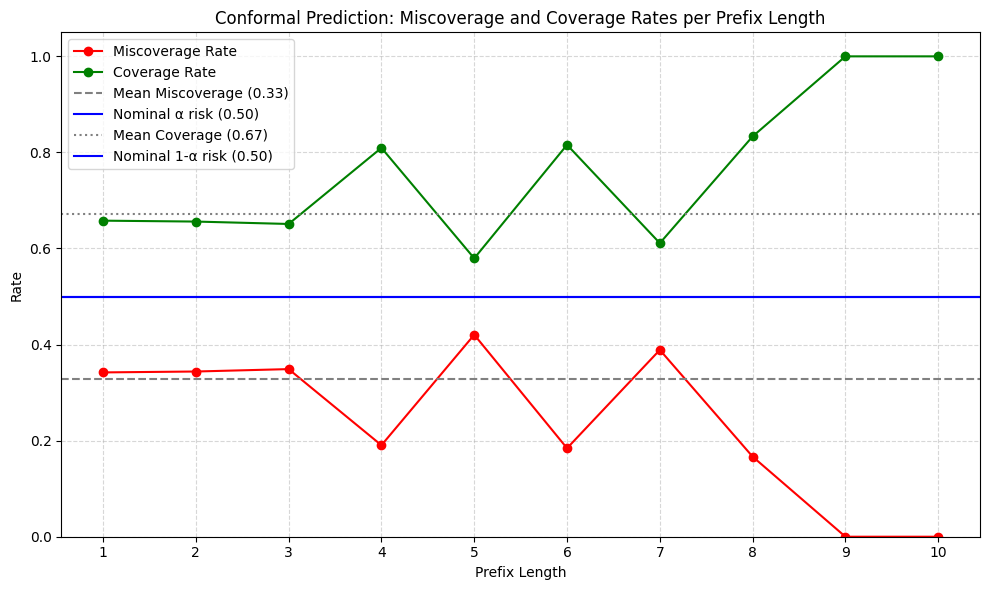

Miscovergae Rate:  0.21891058581706063 <= 0.25
Coverage Rate:  0.7810894141829394 >= 0.75


Miscovergae Rates per prefix length:  {1: 0.2635514018691589, 2: 0.3383177570093458, 3: 0.07797270955165692, 4: 0.18571428571428572, 5: 0.18181818181818182, 6: 0.18421052631578946, 7: 0.05555555555555555, 8: 0.16666666666666666, 9: 0.0, 10: 0.0}
Covergae Rates per prefix length:  {1: 0.7364485981308411, 2: 0.6616822429906541, 3: 0.9220272904483431, 4: 0.8142857142857143, 5: 0.8181818181818181, 6: 0.8157894736842105, 7: 0.9444444444444444, 8: 0.8333333333333334, 9: 1.0, 10: 1.0}


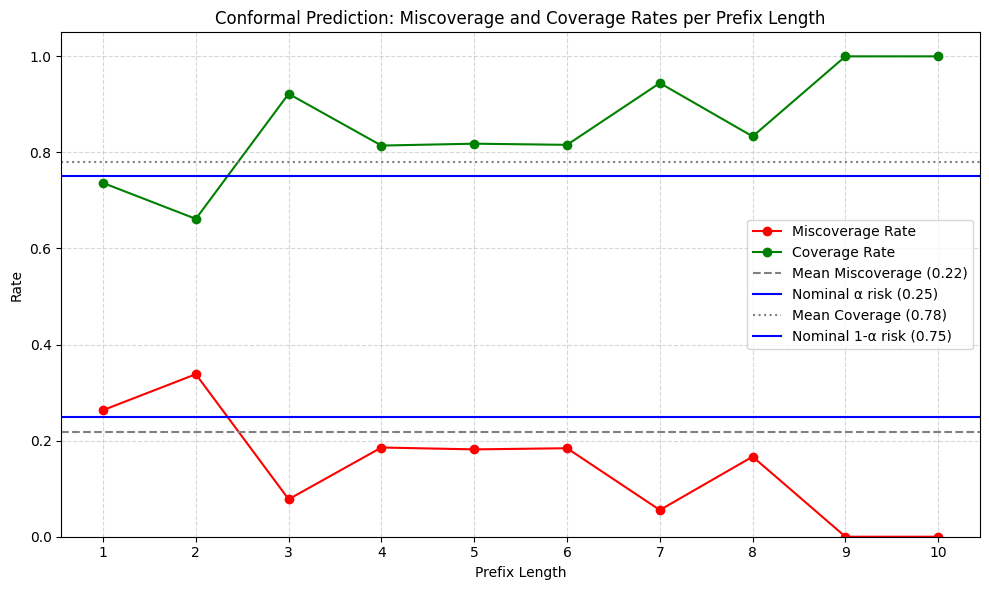

Miscovergae Rate:  0.13206577595066804 <= 0.1
Coverage Rate:  0.867934224049332 >= 0.9


Miscovergae Rates per prefix length:  {1: 0.09906542056074766, 2: 0.2635514018691589, 3: 0.06432748538011696, 4: 0.09047619047619047, 5: 0.09090909090909091, 6: 0.02631578947368421, 7: 0.05555555555555555, 8: 0.16666666666666666, 9: 0.0, 10: 0.0}
Covergae Rates per prefix length:  {1: 0.9009345794392524, 2: 0.7364485981308411, 3: 0.935672514619883, 4: 0.9095238095238095, 5: 0.9090909090909091, 6: 0.9736842105263158, 7: 0.9444444444444444, 8: 0.8333333333333334, 9: 1.0, 10: 1.0}


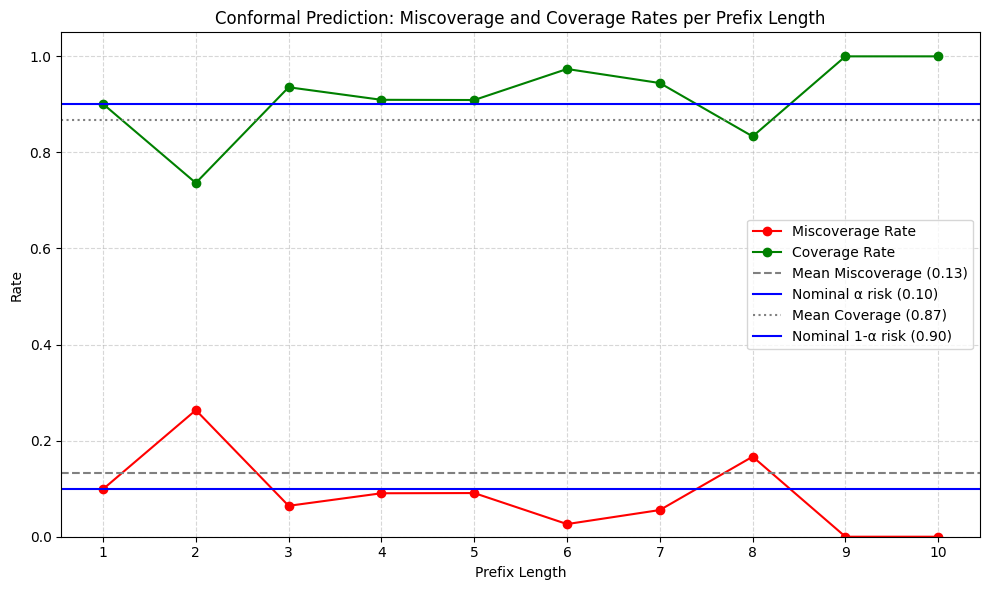

In [7]:

results_coverage(conf_ev_obj=conf_ev_obj,
                 all_results_set=results_all,
                 thresholds=q_fitness_prefix_lens,
                 alpha=alpha_low_risk)

results_coverage(conf_ev_obj=conf_ev_obj,
                 all_results_set=results_all,
                 thresholds=r_fitness_prefix_lens,
                 alpha=alpha_risk)

results_coverage(conf_ev_obj=conf_ev_obj,
                 all_results_set=results_all,
                 thresholds=z_fitness_prefix_lens,
                 alpha=alpha_high_risk)

## Size

In [8]:
def results_size(all_set: Dict, miscov_set: Dict, alpha: float):
    
    sizes_cov_sets,\
    avg_size_cov_set,\
    sizes_miscov_set,\
    avg_size_miscov_set = conf_ev_obj.size(all_set=all_set,
                                           miscov_set=miscov_set)

    print("Risk Level: ", alpha)
    print("Sizes for coverage set with guarentee:", 1-alpha, ":", sizes_cov_sets)
    print("Avergae size for coverage sets guarentee:", 1-alpha, ":", avg_size_cov_set, "\n")
    
    print("Sizes for miscoverage set with risk level:", alpha, ":", sizes_miscov_set)
    print("Avergae size for miscoverage set with risk level:", alpha, ":", avg_size_miscov_set, "\n")


In [9]:
results_size(all_set=results_all, miscov_set=results_low_risk, alpha=alpha_low_risk)
results_size(all_set=results_all, miscov_set=results_risk, alpha=alpha_risk)
results_size(all_set=results_all, miscov_set=results_high_risk, alpha=alpha_high_risk)

Risk Level:  0.5
Sizes for coverage set with guarentee: 0.5 : {1: 305, 2: 300, 3: 293, 4: 114, 5: 42, 6: 21, 7: 11, 8: 5, 9: 2, 10: 1}
Avergae size for coverage sets guarentee: 0.5 : 109.4 

Sizes for miscoverage set with risk level: 0.5 : {1: 230, 2: 235, 3: 220, 4: 96, 5: 46, 6: 17, 7: 7, 8: 1, 9: 0, 10: 0}
Avergae size for miscoverage set with risk level: 0.5 : 85.2 

Risk Level:  0.25
Sizes for coverage set with guarentee: 0.75 : {1: 425, 2: 414, 3: 407, 4: 159, 5: 73, 6: 32, 7: 16, 8: 5, 9: 2, 10: 1}
Avergae size for coverage sets guarentee: 0.75 : 153.4 

Sizes for miscoverage set with risk level: 0.25 : {1: 110, 2: 121, 3: 106, 4: 51, 5: 15, 6: 6, 7: 2, 8: 1, 9: 0, 10: 0}
Avergae size for miscoverage set with risk level: 0.25 : 41.2 

Risk Level:  0.1
Sizes for coverage set with guarentee: 0.9 : {1: 489, 2: 486, 3: 474, 4: 191, 5: 82, 6: 37, 7: 17, 8: 5, 9: 2, 10: 1}
Avergae size for coverage sets guarentee: 0.9 : 178.4 

Sizes for miscoverage set with risk level: 0.1 : {1: 46, 